
# <span style="color:rgb(213,80,0)">Tutorial 2 \- Change the Control Protocol</span>

## Introduction

In this tutorial, we will use a P2D model to simulate the discharge of an NMC\-Graphite cell at different rates. After completing this tutorial, you should have a working knowledge of:

-  Basics of the control protocol definitions in BattMo
-  The link between battery discharge rate and simulation time
-  How to setup and execute a parameter sweep

We'll use the same model from Tutorial 1.


In [1]:
jsonstruct = parseBattmoJson('Examples/jsondatafiles/sample_input.json');

## Explore the Control Protocol

The control protocol is defined in the JSON parameter file and parsed into the MATLAB structure. Once the JSON parameter file has been read into MATLAB as a jsonstruct, its properties can be modified programmatically.


Let's begin by exploring the control protocol definition with the following command:


In [2]:
disp(jsonstruct.Control)

         controlPolicy: 'CCDischarge'
                 DRate: 1
    lowerCutoffVoltage: 3
    upperCutoffVoltage: 4.1000
             dIdtLimit: 0.0100
             dEdtLimit: 0.0100
            rampupTime: 0.1000


Here, we can see that the control policy follows the schema for a constant current discharge (CCDischarge). The three main control parameters in this schema are the CRate, lowerCutoffVoltage, and upperCutoffVoltage. Let's first try changing the protocol to discharge at a rate of C/10 to a lower cutoff voltage of 3 V.


In [3]:
jsonstruct.Control.CRate = 0.1;
jsonstruct.Control.lowerCutoffVoltage = 3.0;


Remember that if we change the rate of the discharge then we also need to change the duration of the simulation. To do this we can explore the TimeStepping property of the structure.


In [4]:
disp(jsonstruct.TimeStepping)

            totalTime: 5040
    numberOfTimeSteps: 150
            useRampup: 1


The total duration of the simulation is given by the totalTime property. We can adjust it to an appropriate duration using the following command.


In [5]:
jsonstruct.TimeStepping.totalTime = (1./jsonstruct.Control.CRate) .* 3600 .* 1.1;


This sets the total time of the simulation to be 10% longer than the expected duration based on the C\-Rate. We can then run the simulation and plot the discharge curve.


In [6]:
output = runBatteryJson(jsonstruct);

Solving timestep 001/155:          -> 8 Seconds, 250 Milliseconds
| It # | ctrl_EIequation (cell) | ctrl_controlEquation (cell) | ne_co_am_sd_massCons (cell) | ne_co_am_sd_solidDiffusionEq (cell) | ne_co_chargeCons (cell) | pe_co_am_sd_massCons (cell) | pe_co_am_sd_solidDiffusionEq (cell) | pe_co_chargeCons (cell) | elyte_chargeCons (cell) | elyte_massCons (cell) |
|    1 | 3.01e-03               |*0.00e+00                    |*0.00e+00                    |*0.00e+00                            |*0.00e+00                |*0.00e+00                    |*0.00e+00                            |*0.00e+00                |*0.00e+00                |*0.00e+00              |
|    2 |*1.36e-12               |*0.00e+00                    | 4.21e-02                    | 4.21e-02                            | 3.36e-02                | 1.40e-02                    | 1.40e-02                            | 1.00e-02                | 6.78e-02                | 4.54e-02              |
|    3 |*1.36e-12           


retrieve the states from the simulation result



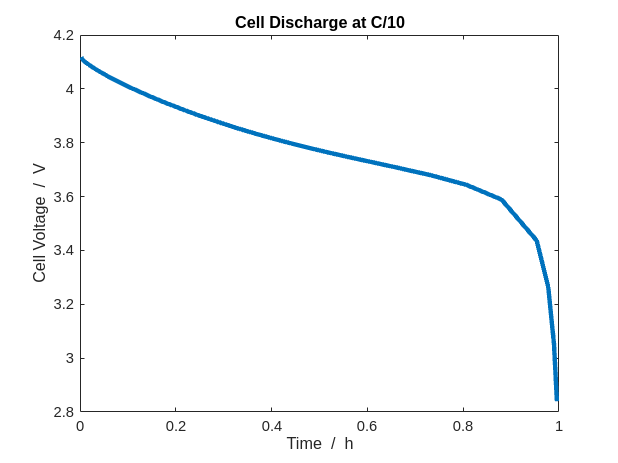

In [7]:
states = output.states;

% extract the time and voltage quantities
time = cellfun(@(state) state.time, states);
voltage = cellfun(@(state) state.('Control').E, states);

% plot the discharge curve in a new figure
figure();
plot((time/hour), voltage, '-', 'linewidth', 3)
xlabel('Time  /  h')
ylabel('Cell Voltage  /  V')
title('Cell Discharge at C/10')

## Setup and Run a Parameter Sweep

Now, let's setup and run a paramter sweep that simulates the performance of the cell at many different rates. To do this, we can define the different rates that we want to simulate in a vector and then use a for\-loop to simulate the cell discharge at each value from the vector. We can also store the outputs of the various simulations as elements in a MATLAB cell array so that they are accessible at the end of the sweep.


In [8]:
% create a vector of different c-rates for the parameter sweep
CRates = [1, 2, 3];

% instantiate and empty cell array to store the outputs of the simulations
output = cell(size(CRates));

% instantiate an empty figure
figure()

% use a for-loop to iterate through the vector of c-rates
for i = 1 : numel(CRates)
    % modify the value for the c-rate in the control definition and update
    % the total duration of the simulation accordingly
    jsonstruct.Control.CRate = CRates(i);
    jsonstruct.TimeStepping.totalTime = (1./jsonstruct.Control.CRate) .* 3600 .* 1.2;

    % run the simulation and store the results in the output cell array
    output{i} = runBatteryJson(jsonstruct);

    % retrieve the states from the simulation result
    states = output{i}.states;

    % extract the time and voltage quantities
    time = cellfun(@(state) state.time, states);
    voltage = cellfun(@(state) state.('Control').E, states);

    % plot the discharge curve in the figure
    plot((time/hour), voltage, '-', 'linewidth', 3)
    hold on
end

Solving timestep 001/155:                     -> 900 Milliseconds
| It # | ctrl_EIequation (cell) | ctrl_controlEquation (cell) | ne_co_am_sd_massCons (cell) | ne_co_am_sd_solidDiffusionEq (cell) | ne_co_chargeCons (cell) | pe_co_am_sd_massCons (cell) | pe_co_am_sd_solidDiffusionEq (cell) | pe_co_chargeCons (cell) | elyte_chargeCons (cell) | elyte_massCons (cell) |
|    1 | 3.01e-03               |*0.00e+00                    |*0.00e+00                    |*0.00e+00                            |*0.00e+00                |*0.00e+00                    |*0.00e+00                            |*0.00e+00                |*0.00e+00                |*0.00e+00              |
|    2 |*1.36e-12               |*0.00e+00                    | 2.16e-02                    | 2.16e-02                            | 1.72e-02                | 3.64e-03                    | 3.64e-03                            | 2.60e-03                | 1.85e-02                | 2.53e-02              |
|    3 |*9.20e-13           


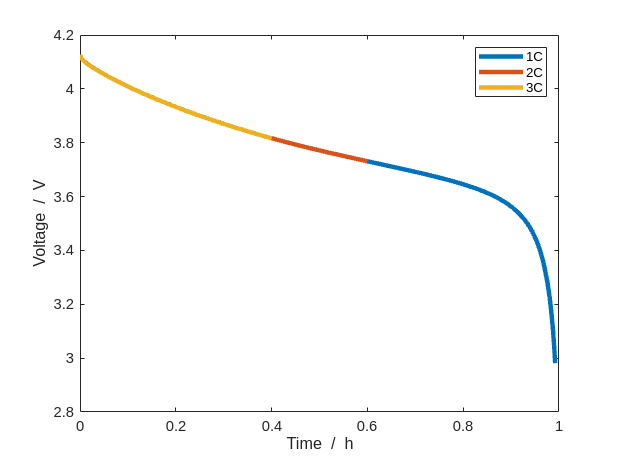

In [9]:
hold off
xlabel('Time  /  h')
ylabel('Voltage  /  V')
legend('1C', '2C', '3C')


Often, it is a more direct comparison of the discharge curves to plot against an x\-axis of capacity rather than time. We can use the following commands to make such a plot.


In [10]:
% instantiate an empty figure
figure()

% use a for-loop to iterate through the vector of c-rates
for i = 1 : numel(output)
    % modify the value for the c-rate in the control definition and update
    % the total duration of the simulation accordingly
    jsonstruct.Control.CRate = CRates(i);
    jsonstruct.TimeStepping.totalTime = (1./jsonstruct.Control.CRate) .* 3600 .* 1.2;

    % run the simulation and store the results in the output cell array
    output{i} = runBatteryJson(jsonstruct);

    % retrieve the states from the simulation result
    states = output{i}.states;

    % extract the time, voltage, and current quantities
    time = cellfun(@(state) state.time, states);
    voltage = cellfun(@(state) state.('Control').E, states);
    current = cellfun(@(state) state.('Control').I, states);

    % calculate the capacity
    capacity = time .* current;

    % plot the discharge curve in the figure
    plot((capacity/(hour*milli)), voltage, '-', 'linewidth', 3)
    hold on
end

Solving timestep 001/155:                     -> 900 Milliseconds
| It # | ctrl_EIequation (cell) | ctrl_controlEquation (cell) | ne_co_am_sd_massCons (cell) | ne_co_am_sd_solidDiffusionEq (cell) | ne_co_chargeCons (cell) | pe_co_am_sd_massCons (cell) | pe_co_am_sd_solidDiffusionEq (cell) | pe_co_chargeCons (cell) | elyte_chargeCons (cell) | elyte_massCons (cell) |
|    1 | 3.01e-03               |*0.00e+00                    |*0.00e+00                    |*0.00e+00                            |*0.00e+00                |*0.00e+00                    |*0.00e+00                            |*0.00e+00                |*0.00e+00                |*0.00e+00              |
|    2 |*1.36e-12               |*0.00e+00                    | 2.16e-02                    | 2.16e-02                            | 1.72e-02                | 3.64e-03                    | 3.64e-03                            | 2.60e-03                | 1.85e-02                | 2.53e-02              |
|    3 |*9.20e-13           


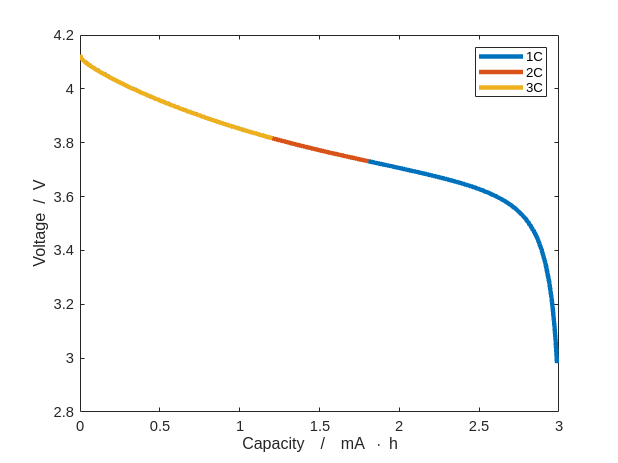

In [11]:
hold off
xlabel('Capacity  /  mA \cdot h')
ylabel('Voltage  /  V')
legend('1C', '2C', '3C')

## Summary

In this tutorial, we explored the basic structure of the control protocol definition and made changes to simulate cell discharge at a variety of rates. We showed that the control protocol is defined as part of the overall BattMo parameter structure. It can be modified by changing the properties of the Control structure. We learned that the total duration of the simulation is dependent on the rate of the battery discharge, and should be updated accordingly. Finally, we showed how to setup and execute a basic parameter sweep by defining a vector with different C\-rates and using a for\-loop to simulate the cell discharge at each rate.

